##### Importacion de librerias

In [1]:
import time
import numpy
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kstest, shapiro, norm, chi2, chi2_contingency, norm
import pandas as pd
import math
import json
import sklearn
import collections
from shapely.geometry import MultiPolygon, Polygon, Point
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (5,5)

# Ejercicio 1

#### Generador XORShift

In [2]:
class XORShiftGenerator:

  PERIOD = 2**64
 
  def __init__(self,external_seed):
    self.seed = external_seed % self.PERIOD
    
  #funcion para generar un numero pseudo-aleatorio
  def random(self):
    seed_tuple = (23,13,58)
    self.seed = (self.seed ^ (self.seed << seed_tuple[0])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed >> seed_tuple[1])) % self.PERIOD
    self.seed = (self.seed ^ (self.seed << seed_tuple[2])) % self.PERIOD
    return self.seed
 
  #funcion para generar un numero pseudo-aleatorio entre 0 y 1
  def uniform_random(self):
    return self.random() / self.PERIOD

  def generate_sample(self, n):
    sample = []
    for i in range(n):
        sample.append(self.random())
    return sample

  def generate_uniform_sample(self, n):
    sample = []
    for i in range(n):
        sample.append(self.uniform_random())
    return sample

#### Generador GCL (Concruencial Lineal)

In [3]:
class GCL:
    # datos provistos
    
    # modulo
    m = 2**32
    
    # multiplicador
    a = 1013904223

    # incremento
    c = 1664525
    
    def __init__(self,seed):
        self.xn = seed
        
    def random(self):
        self.xn = (self.xn*self.a + self.c) % self.m
        return self.xn

    def uniform_random(self):
        return self.random() / self.m
    
    def generate_sample(self, n):
        sample = []
        for i in range(n):
            sample.append(self.random())
        return sample

    def generate_uniform_sample(self, n):
        sample = []
        for i in range(n):
            sample.append(self.uniform_random())
        return sample

In [4]:
generator = XORShiftGenerator(int(time.time()))

#### Muestra de 1000 numeros | XORShift

In [5]:
generatedX = generator.generate_sample(1000)
generatedY = generator.generate_sample(1000)
uniform_generatedX = generator.generate_uniform_sample(1000)
uniform_generatedY = generator.generate_uniform_sample(1000)

In [6]:
generatedX[0:5]

[5778578950870166996,
 3779774011070313607,
 3718535141068734540,
 12877879812028789216,
 4932351810335518931]

In [7]:
uniform_generatedX[0:5]

[0.6705396928382041,
 0.03949477288084978,
 0.597354760239944,
 0.9502593898301503,
 0.555714185683222]

#### Graficos de la muestra

Con este grafico facilmente se aprecia como es la distribucion de los valores generados. Vemos que no se presenta una acumulacion en un sector especifico, sino que estan bastante repartidos.

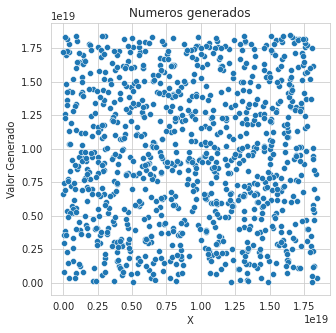

In [8]:
sns.scatterplot(x=generatedX, y=generatedY)
plt.title("Numeros generados")
plt.xlabel("X")
plt.ylabel("Valor Generado")
plt.show()

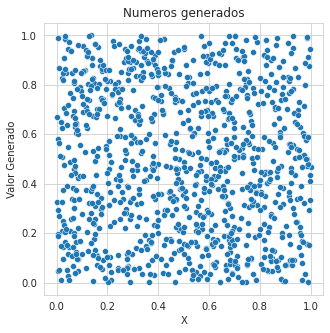

In [9]:
sns.scatterplot(x=uniform_generatedX, y=uniform_generatedY)
plt.title("Numeros generados")
plt.xlabel("X")
plt.ylabel("Valor Generado")
plt.show()

Si contabilizamos entonces cuantos puntos caen en cada intervalo, vemos que no se presentan grandes diferencias en cada uno de ellos.

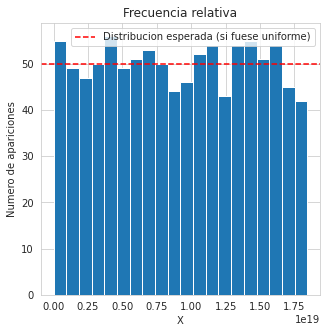

In [10]:
plt.hist(generatedX,bins=20)
plt.axhline(
    y=1000 / 20,
    color="r",
    linestyle="--",
    label="Distribucion esperada (si fuese uniforme)",
)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")

plt.legend()
plt.show()

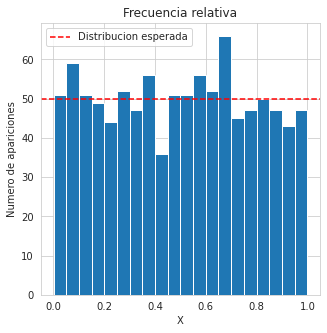

In [11]:
plt.hist(uniform_generatedX,bins=20)
plt.title('Frecuencia relativa')
plt.ylabel("Numero de apariciones")
plt.xlabel("X")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

In [12]:
# parte entera del promedio de los padrones
seed = int((99289 + 96453 + 100853 + 97839 )/4)
gcl_generator = GCL(seed) 

#### Muestra de 1000 numeros | GCL 

In [13]:
gcl_generated = []
gcl_uniform_generated = []
for i in range(1000):
    gcl_generated.append(gcl_generator.random())
    gcl_uniform_generated.append(gcl_generator.uniform_random())

#### Graficos de la muestra

Vemos rapidamente con el scatterplot que la densidad de puntos se expresa de la misma manera en ambos generadores.

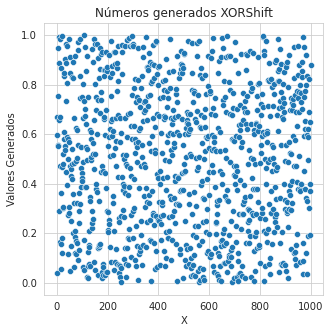

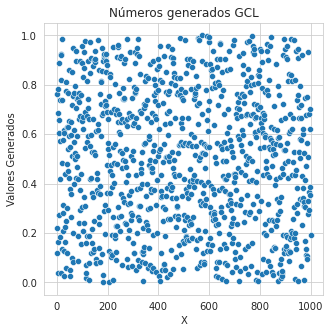

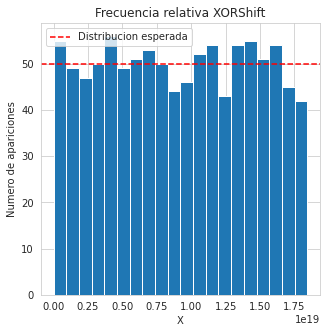

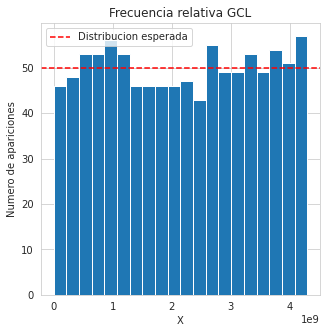

In [14]:
sns.scatterplot(data=uniform_generatedX)
plt.title('Números generados XORShift')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

sns.scatterplot(data=gcl_uniform_generated)
plt.title('Números generados GCL')
plt.xlabel("X")
plt.ylabel("Valores Generados")
plt.show()

plt.hist(generatedX,bins=20)
plt.title('Frecuencia relativa XORShift')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

plt.hist(gcl_generated,bins=20)
plt.title('Frecuencia relativa GCL')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.axhline(
    y=1000 / 20,
    xmin=0,
    xmax=1,
    color="r",
    linestyle="--",
    label="Distribucion esperada",
)
plt.legend()
plt.show()

# Ejercicio 2

### Test de Kolmogorov | XORShift

In [15]:
generator = XORShiftGenerator(int(time.time()))

In [16]:
def kolmorogov_test(sample):
    tested = kstest(sample, 'uniform')
    if tested[1] >= 0.05:
        print("El test acepta la hipotesis nula.")
    else:
        print("El test rechaza la hipótesis nula")
    print("Estadistico: {:.4f} ".format(tested[0]))
    print("P Valor: {:.4f} ".format(tested[1]))

In [17]:
big_sample = generator.generate_uniform_sample(10000)
kolmorogov_test(big_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0086 
P Valor: 0.4530 


In [18]:
small_sample = generator.generate_uniform_sample(1000)
kolmorogov_test(small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0232 
P Valor: 0.6484 


###  Test de Kolmogorov | GCL

In [19]:
generator = GCL(int(time.time()))

In [20]:
gcl_big_sample = generator.generate_uniform_sample(10000)
kolmorogov_test(gcl_big_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0111 
P Valor: 0.1725 


In [21]:
gcl_small_sample = generator.generate_uniform_sample(1000)
kolmorogov_test(gcl_small_sample)

El test acepta la hipotesis nula.
Estadistico: 0.0250 
P Valor: 0.5513 


### Test Chi-Cuadrado | XORShift

In [22]:
generator = XORShiftGenerator(int(time.time()))

n = 10000
k = 10
p = 1/k

sample = generator.generate_uniform_sample(n)

str(sample[0:5]) + '...'

'[0.2820073926215317, 0.20491340380747197, 0.17034268515563694, 0.6932261856346373, 0.3728498125069481]...'

#### Discretisacion de la muestra

In [23]:
def in_range(value, start, end):
    return value > start and value <= end
       
# asigna un valor (a.k.a value) a un bind
# k es la cantidad de binds
def mapper(value, k):

    width = 1.0 / k
    
    for i in range(k):
        start = i * width
        end = (i + 1) * width
        if in_range(value, start, end): return i
    
    raise Exception("number generated is invalid")
    
def frecuency_sum(values):
    elements_count = collections.Counter(values)
    count = []
    for key, value in elements_count.items():
       count.insert(key, value)
    return count

In [24]:
mapped_values = list(map(lambda value: mapper(value, k), sample))
"{}...".format(str(mapped_values[0:5]))

'[2, 2, 1, 6, 3]...'

In [25]:
frecuencies = frecuency_sum(mapped_values)
frecuencies

[1016, 976, 987, 999, 991, 977, 997, 987, 1080, 990]

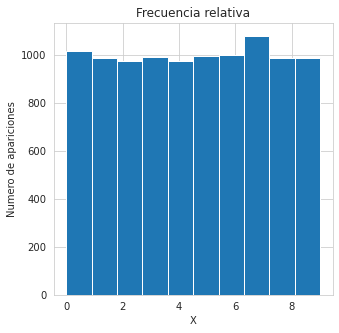

In [26]:
plt.hist(mapped_values, bins=k)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.show()

#### Dispercion

##### Frecuencias Actuales

In [27]:
frecuencies

[1016, 976, 987, 999, 991, 977, 997, 987, 1080, 990]

##### Frecuencias Esperadas

In [28]:
f_e = int(n * p)
[f_e, f_e, f_e, f_e, f_e, f_e, f_e, f_e, f_e, f_e]

[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]

#### Calculemos la dispercion:

\begin{equation}
D^2 =\sum_{i=1}^K \frac{(N_i - n p_i) ^2}{n p_i}
\end{equation}

In [29]:
def dispersion(n, p, frecuencies):
    k = len(frecuencies)
    
    sum_ = 0
    
    dispersiones = []
    
    for i in range(k):
        dispersion_i = (frecuencies[i] - n * p) ** 2 / (n * p)
        dispersiones.append(dispersion_i) 
        sum_ = sum_ + dispersion_i 
    
    print("dispersiones: {}".format(dispersiones))
    
    return sum_

In [30]:
def test_chi2(frecuencies, k):
    upper_limit = chi2.ppf(0.95, df=k-1)
    d2 = dispersion(n, 1/k, frecuencies)
    print(d2, upper_limit)
    if d2 < upper_limit:

        print("El test acepta la hipotesis nula")
    else:
        print("El test rechaza la hipotesis nula")

In [31]:
test_chi2(frecuencies, k)

dispersiones: [0.256, 0.576, 0.169, 0.001, 0.081, 0.529, 0.009, 0.169, 6.4, 0.1]
8.29 1.6918977604620448e+01
El test acepta la hipotesis nula


### Test Chi-Cuadrado | GCL

In [32]:
generator = GCL(int(time.time()))
sample_gcl = generator.generate_uniform_sample(n)
str(sample_gcl[0:5]) + '...'

'[0.1286811251193285, 0.1792660963255912, 0.10562925972044468, 0.5033102121669799, 0.5955144632607698]...'

In [33]:
mapped_values = list(map(lambda value: mapper(value, k), sample))
str(mapped_values[0:5]) + '...'

'[2, 2, 1, 6, 3]...'

In [34]:
frecuencies = frecuency_sum(mapped_values)
frecuencies

[1016, 976, 987, 999, 991, 977, 997, 987, 1080, 990]

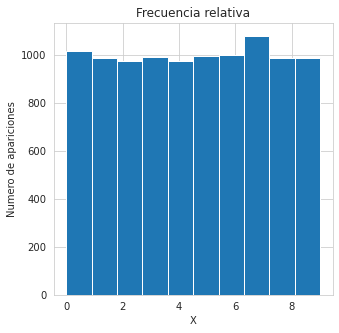

In [35]:
plt.hist(mapped_values, bins=k)
plt.title('Frecuencia relativa')
plt.xlabel("X")
plt.ylabel("Numero de apariciones")
plt.show()

In [36]:
test_chi2(frecuencies, k)

dispersiones: [0.256, 0.576, 0.169, 0.001, 0.081, 0.529, 0.009, 0.169, 6.4, 0.1]
8.29 16.918977604620448
El test acepta la hipotesis nula


### Test de independencia Bernoulli | XORShift

In [37]:
m=6

def generate_matrix(generator):
    population = []
    for i in range(0,5):
        numbers = generator.generate_uniform_sample(m)
        frecuencies=numpy.histogram(numbers, bins=[0, 0.5, 1])
        population.append(frecuencies[0])
    
    return population
    
generator = XORShiftGenerator(int(time.time()))
population = generate_matrix(generator)


D2, p, dof, ex = chi2_contingency(numpy.array(population))

limiteSuperior = chi2.ppf(0.95, df=dof)

df = pd.DataFrame(numpy.array(population), columns=['Sale 0', 'Sale 1'])


print("Limite superior: {:.2f} ".format(limiteSuperior))
print("Estadistico: {:.2f} ".format(D2))
print("Tabla de frecuencies: \n{}".format(df))

if D2 < limiteSuperior:
    print("\nEl test acepta la hipotesis nula")
else:
    print("\nEl test rechaza la hipotesis nula")


Limite superior: 9.49 
Estadistico: 7.78 
Tabla de frecuencies: 
   Sale 0  Sale 1
0       5       1
1       3       3
2       1       5
3       4       2
4       5       1

El test acepta la hipotesis nula


### Test de independencia Bernoulli | GCL

In [38]:
generator = GCL(int(time.time()))
population = generate_matrix(generator)


D2, p, dof, ex = chi2_contingency(numpy.array(population))

upper_limit = chi2.ppf(0.95, df=dof)

df = pd.DataFrame(numpy.array(population), columns=['Sale 0', 'Sale 1'])


print("Limite superior: {:.2f} ".format(upper_limit))
print("Estadistico: {:.2f} ".format(D2))
print("Tabla de frecuencias: \n{}".format(df))

if D2 < upper_limit:
    print("\nEl test acepta la hipotesis nula")
else:
    print("\nEl test rechaza la hipotesis nula")

Limite superior: 9.49 
Estadistico: 1.33 
Tabla de frecuencias: 
   Sale 0  Sale 1
0       4       2
1       3       3
2       3       3
3       3       3
4       2       4

El test acepta la hipotesis nula


# Ejercicio 3

In [39]:
# genexp genera un valor de una variable Exp(lamda) utilizando equivalencia de eventos contra una uniforme (0,1)
# ver: pag.4 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def genexp(u, lam=1):
    return -np.log(1-u) / lam # transformacion inversa

In [40]:
# exponential normal probabilistic density function
def normalpdf(x, mu=0, sigma=1):
    var = np.square(sigma)
    return np.exp(-np.square(x - mu) / (2 * var)) / np.sqrt(2 * np.pi * var)

# exponential probabilistic density function
def exppdf(x, lam=1):
    return lam * np.exp(-lam * x)

# gennorm genera valores de una normal de media "mu" y desviación "sigma", utilizando un metodo de aceptación rechazo contra una variable Exp(1)
# ver: pag.9 de https://campusgrado.fi.uba.ar/pluginfile.php/29915/mod_page/content/419/Te%C3%B3rica%204%20Generaci%C3%B3n%20de%20variables%20continuas%20y%20discretas.pdf
def gennorm(generator, N, mu=0, sigma=1):
    t = np.array([genexp(gen.uniform_random()) for _ in range(N)])
    c = np.sqrt(2 * np.e / np.pi)

    # probabilidad de aceptar
    p = normalpdf(t) / (c * exppdf(t))

    z = np.array([])
    for i in range(N):
        if generator.uniform_random() < p[i]:
            r2 = generator.uniform_random()
            val = t[i] if r2 < 0.5 else -t[i]
            z = np.concatenate((z, [sigma * val + mu]))

    return z

## Generado con XorShift

Eficiencia 0.382480


Text(0, 0.5, 'Probilidad')

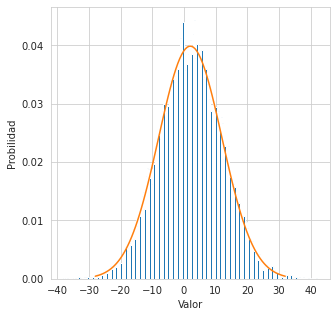

In [41]:
# Generamos una muestra de N=50000 y graficamos el histograma
N=50000
gen = XORShiftGenerator(int(time.time()))

mu = 2.0
sigma = 10.0

data = gennorm(gen, N, mu, sigma)

print("Eficiencia {:f}".format(len(data)/N))

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(data, density=True, bins=200)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.xlabel("Valor")
plt.ylabel("Probilidad")

## Generado con GCL

Eficiencia 0.380280


Text(0, 0.5, 'Probilidad')

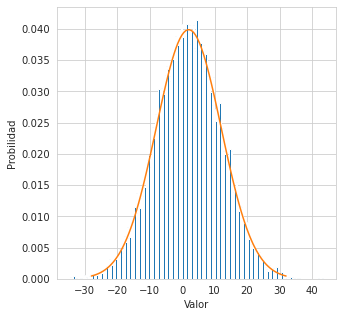

In [42]:
# Generamos una muestra de N=50000 y graficamos el histograma
N=50000
gen = GCL(int(time.time()))

mu = 2.0
sigma = 10.0

data = gennorm(gen, N, mu, sigma)

print("Eficiencia {:f}".format(len(data)/N))

x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(data, density=True, bins=200)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.xlabel("Valor")
plt.ylabel("Probilidad")


## Tests Estadísticos

In [43]:
def cdf(x):
    return norm.cdf(x, loc=mu, scale=sigma)

alfa = 0.05

### Test 1: Kolmogorov-Smirnov

In [44]:
K, pv = kstest(data, cdf)

print("K = %f, p-val = %f" % (K, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

K = 0.005885, p-val = 0.523534
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


### Test 2: Shapiro-Wilk

In [45]:
sorted_data = np.sort(data)

S, pv = shapiro(sorted_data)

print("S = %f, p-val = %f" % (S, pv))
print("Existe evidencia para rechazar que los datos no siguen una distribución normal (2,10)" if pv < alfa else "No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)")

S = 0.999905, p-val = 0.710605
No existe evidencia para afirmar que los datos no se distribuyen de forma normal (2, 10)


/home/ale/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


# Ejercicio 4

La llegada de vehiculos a un estacionamiento sigue un proceso de Poisson de tasa lamda vehiculos/hora.

In [46]:
time_between_arrivals = pd.read_csv('tiempos_entre_arribos.txt', header=None)

time_between_arrivals

,0
0,0.028390
1,0.294435
2,0.048560
3,0.140468
4,0.023268
...,...
9995,0.216236
9996,0.099258
9997,0.163479
9998,0.121538


### Estimacion de la tasa de arribos

In [47]:
arrivals_qty = len(time_between_arrivals)
arrivals_qty

10000

In [48]:
total_time = time_between_arrivals[0].sum()
total_time

1.0111994386169151e+03

In [49]:
lambda_ = arrivals_qty / total_time
print("Tasa de arribos: {} por hora".format(lambda_))

Tasa de arribos: 9.889245996494685 por hora


### Simulacion de llegada de vehiculos con generador | XORShift

Un proceso de Poisson, tiene la caracteristica de que el tiempo entre arribos sigue una distribucion exponencial.

In [50]:
generator = XORShiftGenerator(int(time.time()))

# arrivals
arrivals = []

arrival = 0

# 1 mes en horas
mes = 24 * 30

while arrival < mes:
    # exponencial a partir del generador GCL
    z = genexp(generator.uniform_random(), lambda_)
    arrival = arrival + z
    arrivals.append(arrival)

In [51]:
print("Cantidad de arribos en un mes: {}".format(len(arrivals))) 

Cantidad de arribos en un mes: 7141


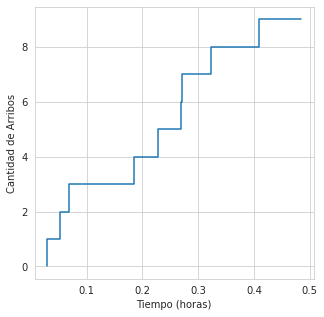

In [52]:
plt.step(arrivals[0:10], range(10))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.show()

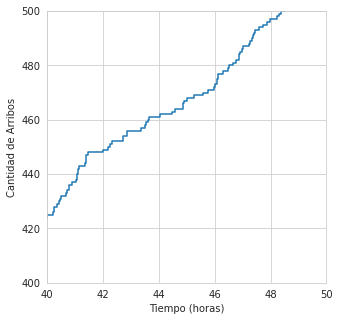

In [53]:
plt.step(arrivals, range(len(arrivals)))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.xlim(40,50)
plt.ylim(400,500)
plt.show()

### Simulacion de llegada de vehiculos con generador | GCL

Un proceso de Poisson, tiene la caracteristica de que el tiempo entre arribos sigue una distribucion exponencial.

In [54]:
generator_gcl = GCL(int(time.time()))

# arrivals
arrivals = []

arrival = 0

# 1 mes en horas
mes = 24 * 30

while arrival < mes:
    # exponencial a partir del generador GCL
    z = genexp(generator_gcl.uniform_random(), lambda_)
    arrival = arrival + z
    arrivals.append(arrival)

In [55]:
print("Cantidad de arribos en un mes: {}".format(len(arrivals))) 

Cantidad de arribos en un mes: 7140


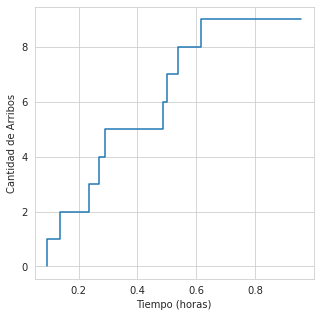

In [56]:
plt.step(arrivals[0:10], range(10))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.show()

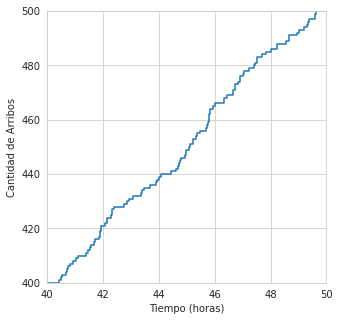

In [57]:
plt.step(arrivals, range(len(arrivals)))
plt.xlabel('Tiempo (horas)')
plt.ylabel('Cantidad de Arribos')
plt.xlim(40,50)
plt.ylim(400,500)
plt.show()

### Generacion 1000 Procesos de Poisson

In [58]:
# cantidad de arribos
n = 750

poisson_processes = []
poisson_processes_gcl = []

for i in range(1000):
    arrivals = []
    arrival = 0
    for i in range(n):
        z = genexp(generator.uniform_random(), lambda_)
        arrival = arrival + z
        arrivals.append(arrival)
    poisson_processes.append(arrivals)

for i in range(1000):
    arrivals = []
    arrival = 0
    for i in range(n):
        z = genexp(generator_gcl.uniform_random(), lambda_)
        arrival = arrival + z
        arrivals.append(arrival)
    poisson_processes_gcl.append(arrivals)

#### Probabilidad de n arribos en un intervalo de tiempo

\begin{equation}
P(N_{(s,t]}=n) = \frac{e^{-\lambda (t-s)} (\lambda (t-s))^n }{n!}
\end{equation}

#### En particular, la probabilidad de n arribos desde el instante 0 a un determinado tiempo t

\begin{equation}
P(N_{(t)}=n) = \frac{e^{-\lambda t} \lambda t^n }{n!}
\end{equation}

In [59]:
def counting_process(t, n, lambda_): 
    return ((math.e ** (-(lambda_ * t))) * ((lambda_ * t) ** n)) / math.factorial(n)

### Probabilidad de que el primer vehiculo arribe antes de los 10 minutos 

#### Estimacion XORShift

In [60]:
summ = 0
for pp in poisson_processes:
     summ += 1 if pp[0] < 10/60 else 0 # primer arribo < 10 min?
estimate = summ/len(poisson_processes) # casos exitosos / casos totales
estimate

0.828

#### Estimacion GCL

In [61]:
summ = 0
for pp in poisson_processes_gcl:
     summ += 1 if pp[0] < 10/60 else 0 # primer arribo < 10 min?
estimate_gcl= summ/len(poisson_processes_gcl) # casos exitosos / casos totales
estimate_gcl

0.799

#### Teorico

Paso 10 minutos a horas. 10 -> 10 / 60 = 0.16

\begin{equation}
P(X_1 < 0.16) = 1 - P(X_1 > 0.16)
\end{equation}

Prababilidad de que el primer arribo sea despues de los 10 minutos, es lo mismo que pedir que durante los primeros 10 minutos no haya arribos

\begin{equation}
P(X_1 > 0.16) = P(N_{(0, 0.16]} = 0)
\end{equation}

\begin{equation}
P(N_{(0,0.16]}=0) = \frac{e^{-\lambda 0.16} (\lambda 0.16)^0 }{0!}
\end{equation}

Tomando que los tiempos entre arribos son en horas. Tenemos que t es (10 * 100) / 60 = 16.6666666667

In [62]:
theo = 1 - counting_process(0.16, 0, lambda_)

In [63]:
abs(theo-estimate)

0.03350614158394849

In [64]:
abs(theo-estimate_gcl)

0.004506141583948575

### Probabilidad de que el undecimo vehiculo arribe despues de los 60 minutos

#### Estimación XORShift

In [65]:
summ = 0
for pp in poisson_processes:
     summ += 1 if pp[10] > 1 else 0 # undecimo arribo > 1h ?
estimate = summ/len(poisson_processes) # casos exitosos / casos totales
estimate

0.583

#### Estimación GCL

In [66]:
summ = 0
for pp in poisson_processes_gcl:
     summ += 1 if pp[10] > 1 else 0 # undecimo arribo > 1h ?
estimate = summ/len(poisson_processes_gcl) # casos exitosos / casos totales
estimate_gcl

0.799

#### Teorico

Paso a horas, 60 min -> 1 h

\begin{equation}
P(X_{11} > 1)
\end{equation}

Esto es lo mismo que pedir que hasta 1 hora, haya <= 10 arribos.

\begin{equation}
P(N_{(0,1]} \leq 10) = \sum\limits_{i=0}^{10} P(N_{(0,1]} = i)
\end{equation}

In [67]:
summation = 0
for i in range(10):
    summation = summation + counting_process(1, i, lambda_)
theo = summation

In [68]:
abs(theo-estimate)

0.12913941604920876

In [69]:
abs(theo-estimate_gcl)

0.3271394160492088

### Probabilidad de que arriben al menos 750 vehiculos antes de las 72 horas

Esto es lo mismo que pedir que hasta 72 horas, haya > 750 arribos.

#### Estimación XORShift

In [70]:
summ = 0
for pp in poisson_processes:
     summ += 1 if pp[749] < 72 else 0 # el arribo 750 es antes de las 72h?
estimate = summ/len(poisson_processes) # casos exitosos / casos totales
estimate

0.074

#### Estimación GCL

In [71]:
summ = 0
for pp in poisson_processes_gcl:
     summ += 1 if pp[749] < 72 else 0 # el arribo 750 es antes de las 72h?
estimate_gcl = summ/len(poisson_processes_gcl) # casos exitosos / casos totales
estimate_gcl

0.075

#### Teorico

\begin{equation}
P(N_{(0,72]} > 750) = 1 - P(N_{(0,72]} <= 750) = 1 - \sum\limits_{i=0}^{750} P(N_{(0,72]} = i)
\end{equation}

In [72]:
summation = 0
results = [] 
for i in range(750):
    if i < 108: # ver anexo
        results.append(counting_process(72, i, lambda_))
        summation = summation + counting_process(72, i, lambda_)
theo = 1 - summation
theo

1.0

Con arribos mayores a 108 no tenemos la posibilidad de calcularlo un un error de overflow. Pero podemos asumir que son practicamente 0, ya que son valores muy pequeños, notar que la sumatoria de los 108 calculos es un valor infimo.

In [73]:
# prob(72, 109, lambda_)

In [74]:
sum(results)

9.335133058845929e-177

In [75]:
abs(theo-estimate)

0.926

In [76]:
abs(theo-estimate_gcl)

0.925

# Ejercicio 5

In [77]:
f = open('caba_barrios.json')
data = json.load(f)

In [78]:
# obtiene las coordenadas de el barrio en formato geojson,
# y mediante la libreria shapely.geometry construye un poligono con ellas.
from shapely.geometry import MultiPolygon, Polygon, Point
def get_polygon_barrio_by_name(name):
    barrios = data["features"]
    for barrio in barrios:
        if barrio["properties"]['BARRIO'] == name:
            coordinates = barrio["geometry"]["coordinates"][0][0]
            print("coordinates: {} ...".format(coordinates[0:5]))
            return Polygon(coordinates)
    raise Exception("barrio not found")

In [79]:
# genera n puntos dentro del poligono
def random_points_in_bounds(polygon, number, generator):
    attempts = 0
    points = []
    while len(points) < number:
        minx, miny, maxx, maxy = polygon.bounds    
        x = minx + ((maxx - minx) * generator.uniform_random())
        y = miny + ((maxy - miny) * generator.uniform_random())
        point = Point(x, y)
        attempts = attempts + 1
        if polygon.contains(point):
            points.append(point)
            
    polygon_area = polygon.area
    polygon_boundary_area = (maxx - minx) * (maxy - miny)
    rendimiento_teorico = polygon_area / polygon_boundary_area
    
    # rendimiento
    print("rendimiento teorico: {}%".format(round(rendimiento_teorico * 100, 2)))
    print("intentos: {}, para generar efectivamente {}, rendimiento: {}%"
          .format(attempts, number, round((number / attempts) * 100, 2)))

    return points

In [80]:
# grafica el poligono y los puntos generados
def plot_polygon_and_points(polygon, points, points_gcl):
    fig, ax = plt.subplots()
    
    # plot the polygon
    xp,yp = polygon.exterior.xy
    ax.plot(xp,yp)
    
    # plot the list of points
    xs = [point.x for point in points]
    ys = [point.y for point in points]
    ax.scatter(xs, ys, c = 'red', label = 'XORShift')
    
    # plot the list of points
    xs = [point.x for point in points_gcl]
    ys = [point.y for point in points_gcl]
    ax.scatter(xs, ys, c = 'blue', label = 'GCL')
    
    ax.legend()    
    plt.show()

In [81]:
generator = XORShiftGenerator(int(time.time()))
generator_gcl = GCL(int(time.time()))

#### Paternal

coordinates: [[-58.46557681285407, -34.59655770780579], [-58.46562010948453, -34.596704306733564], [-58.465540216548725, -34.59664630163081], [-58.46545058351525, -34.59661891152001], [-58.46533988591098, -34.59661194039792]] ...


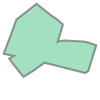

In [82]:
polygon = get_polygon_barrio_by_name("PATERNAL")
polygon

In [83]:
points = random_points_in_bounds(polygon, 20, generator)
points_gcl = random_points_in_bounds(polygon, 20, generator_gcl)

rendimiento teorico: 54.28%
intentos: 33, para generar efectivamente 20, rendimiento: 60.61%
rendimiento teorico: 54.28%
intentos: 39, para generar efectivamente 20, rendimiento: 51.28%


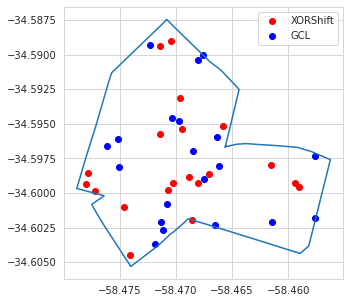

In [84]:
plot_polygon_and_points(polygon, points, points_gcl)

#### Caballito

coordinates: [[-58.43060582833087, -34.60704708859627], [-58.43055990202167, -34.60775365188757], [-58.43054944602487, -34.607918867190364], [-58.430512846566, -34.608513737883264], [-58.43047392413131, -34.60872528515684]] ...


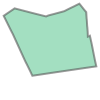

In [85]:
polygon = get_polygon_barrio_by_name("CABALLITO")
polygon

In [86]:
points = random_points_in_bounds(polygon, 20, generator)
points_gcl = random_points_in_bounds(polygon, 20, generator_gcl)

rendimiento teorico: 66.98%
intentos: 34, para generar efectivamente 20, rendimiento: 58.82%
rendimiento teorico: 66.98%
intentos: 30, para generar efectivamente 20, rendimiento: 66.67%


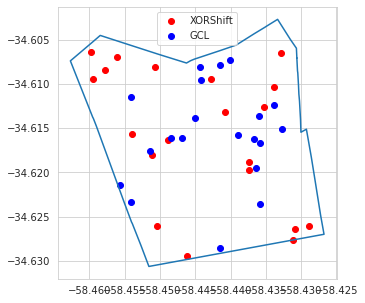

In [87]:
plot_polygon_and_points(polygon, points, points_gcl)

#### Palermo

coordinates: [[-58.42675931727641, -34.55202337340274], [-58.42675824500638, -34.5520237796411], [-58.426655099174575, -34.55199914616127], [-58.42664914796214, -34.55199772487853], [-58.42624608735907, -34.551901464195666]] ...


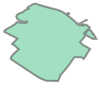

In [88]:
polygon = get_polygon_barrio_by_name("PALERMO")
polygon

In [89]:
points = random_points_in_bounds(polygon, 20, generator)
points_gcl = random_points_in_bounds(polygon, 20, generator_gcl)

rendimiento teorico: 59.03%
intentos: 36, para generar efectivamente 20, rendimiento: 55.56%
rendimiento teorico: 59.03%
intentos: 26, para generar efectivamente 20, rendimiento: 76.92%


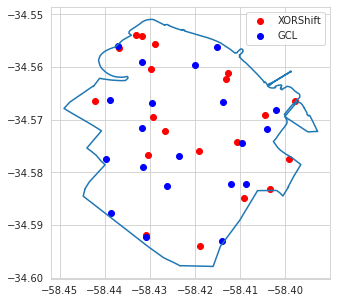

In [90]:
plot_polygon_and_points(polygon, points, points_gcl)

#### Villa Luro

coordinates: [[-58.501537624795354, -34.63183451938719], [-58.5010420985705, -34.632207786848085], [-58.500552695297856, -34.632003566545755], [-58.50054885143212, -34.63200205061806], [-58.49997731679515, -34.63177655337347]] ...


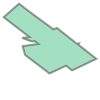

In [91]:
polygon = get_polygon_barrio_by_name("VILLA LURO")
polygon

In [92]:
points = random_points_in_bounds(polygon, 20, generator)
points_gcl = random_points_in_bounds(polygon, 20, generator_gcl)

rendimiento teorico: 41.0%
intentos: 38, para generar efectivamente 20, rendimiento: 52.63%
rendimiento teorico: 41.0%
intentos: 47, para generar efectivamente 20, rendimiento: 42.55%


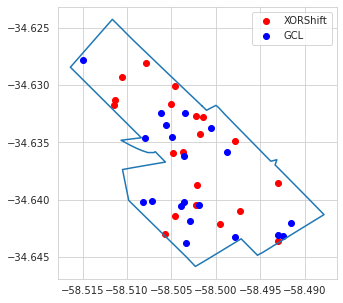

In [93]:
plot_polygon_and_points(polygon, points, points_gcl)

#### Boedo

coordinates: [[-58.41177931480301, -34.63035586936054], [-58.411779271795105, -34.630356649086785], [-58.41165088056365, -34.631530995564205], [-58.411638787000385, -34.631654254966804], [-58.411634504862995, -34.631697895403335]] ...


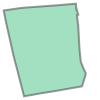

In [94]:
polygon = get_polygon_barrio_by_name("BOEDO")
polygon

In [95]:
points = random_points_in_bounds(polygon, 20, generator)
points_gcl = random_points_in_bounds(polygon, 20, generator_gcl)

rendimiento teorico: 75.8%
intentos: 28, para generar efectivamente 20, rendimiento: 71.43%
rendimiento teorico: 75.8%
intentos: 30, para generar efectivamente 20, rendimiento: 66.67%


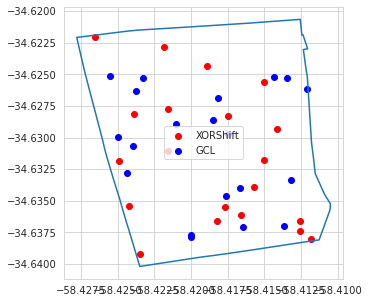

In [96]:
plot_polygon_and_points(polygon, points, points_gcl)